In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from statsmodels.stats.multitest import multipletests
#from statsmodels.discrete.discrete_model import NegativeBinomial
from matplotlib_venn import *

%matplotlib inline
pd.set_option('display.max_rows', 30)


In [2]:
def load_counts(file, ecDNA_len):
    '''
    returns: series
    index: barcode
    '''
    s = pd.read_csv(file,sep='\t',index_col=0)
    #s = select_qc_passed_cells(s)
    s /= ecDNA_len
    return s.squeeze()

def load_backgrounds(file):
    '''
    returns: dataframe
    rows: barcodes
    column: random permutation region
    access as df[barcode.bam]
    '''
    df = pd.read_csv(file,sep='\t',index_col=0)
    #df = select_qc_passed_cells(df)
    return df

def select_qc_passed_cells(df):
    '''
    Returns df subsetted to include only rows passing seurat qc.
    '''
    master = SAMPLE
    m=master.df[master.df['qc_pass_seurat']]
    df=df[df.index.isin(m.index)]
    return df
    
def estimate_pvalues(observed,backgrounds):
    # Set up dataframe of observed featurecounts    
    df = pd.DataFrame(observed)
    df.columns=['Observed']
    
    # Estimate empirical p
    bg=backgrounds
    df['empirical p-val']=observed.index.map(lambda x: ((observed[x] <= bg.loc[x]).sum()+1) / (len(bg.loc[x])+1))
    
    # Sample standard deviation
    df['z-score']=observed.index.map(lambda x: abs(observed[x] - bg.loc[x].mean())/bg.loc[x].std())
    
    return df

def gen_histograms(observed,backgrounds,outfile_prefix=None):
    w=6
    h=6
    df = estimate_pvalues(observed,bg)
    observed=observed.loc[df.index]
    backgrounds=backgrounds.loc[df.index]
    fig,axes = plt.subplots(h,w, figsize=(20,20))
    for i in range(h*w):
        sns.histplot(ax=axes[i//h,i%h],data=backgrounds.iloc[i,:],binwidth=1)
        # observed value
        axes[i//h,i%h].axvline(df.iloc[i,0],c='red')
        text = 'empirical p<'+str(round(df.iloc[i,1],3))
        axes[i//h,i%h].text(0.9,0.8,text,horizontalalignment='right',transform=axes[i//h,i%h].transAxes)
    if outfile_prefix != None:
        fig.savefig(outfile_prefix+'.svg')
        fig.savefig(outfile_prefix+'.png')
        
def classify(fgs,bg):
    classifications = pd.DataFrame()
    for i in range(len(fgs[0:])):
        df = estimate_pvalues(fgs[i],bg)
        e = multipletests(df['empirical p-val'],alpha=0.20,method='fdr_bh')
        base='ecDNA'+str(i+1)
        classifications[base+"_z-score"] = df['z-score']
        classifications[base+"_p-val"] = df['empirical p-val']
        classifications[base+"_q-val"] = e[1]
        classifications[base+"_status"] = e[0]
        #classifications[base+"_status"] = (df < 0.05)
    return classifications


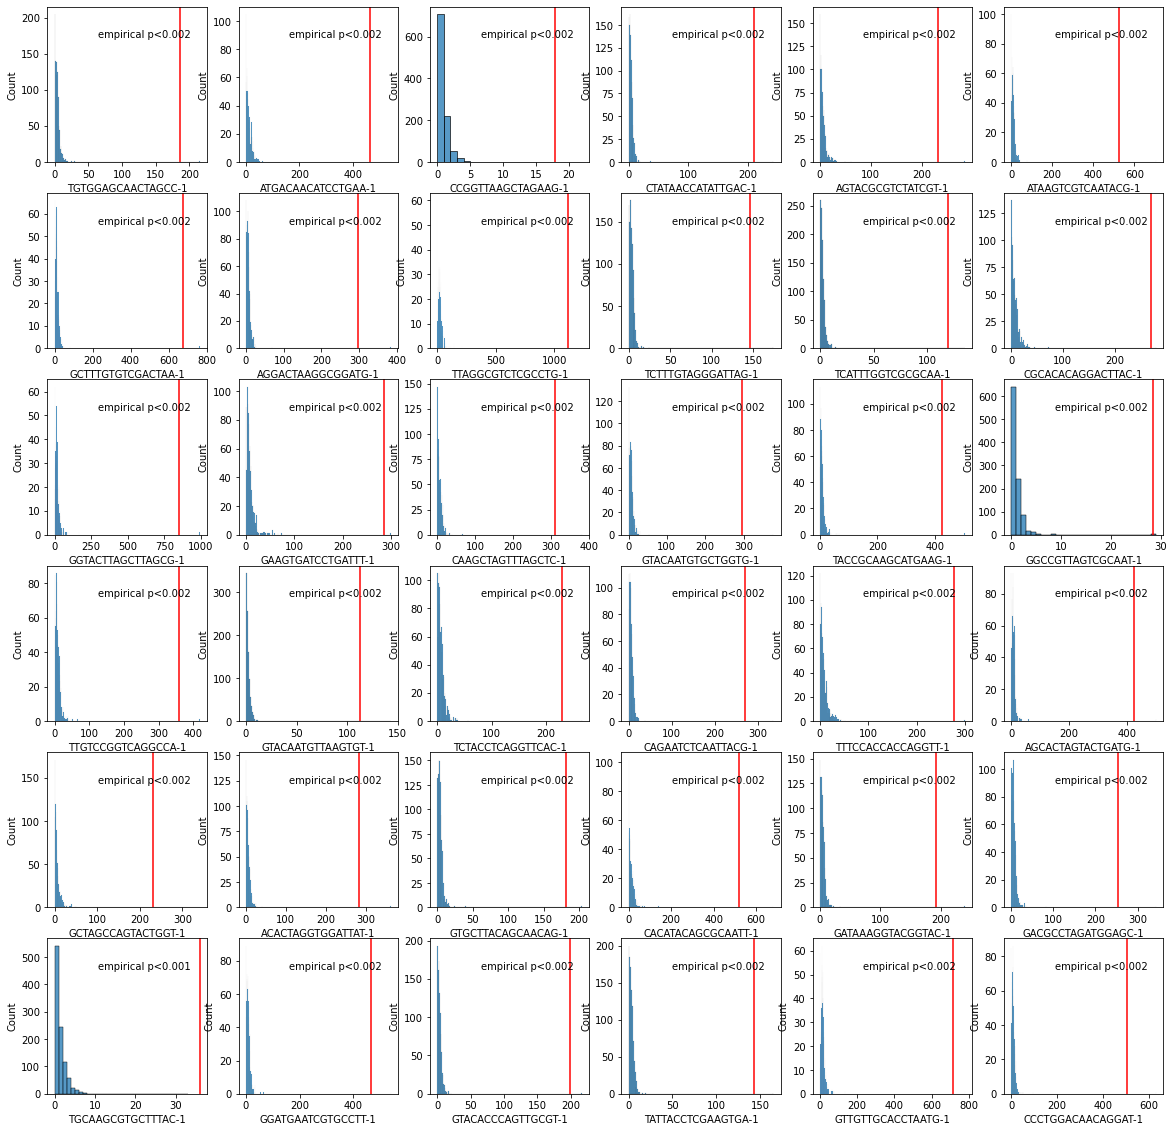

In [7]:
# COLO320HSR
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
SAMPLE=None
fg1 = load_counts('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320HSR/COLO320HSR_ecDNA0.tsv',2.007952)
bg = load_backgrounds('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320HSR/COLO320HSR_bkgd.tsv')
gen_histograms(fg1,bg)
hsr_c = classify([fg1],bg)

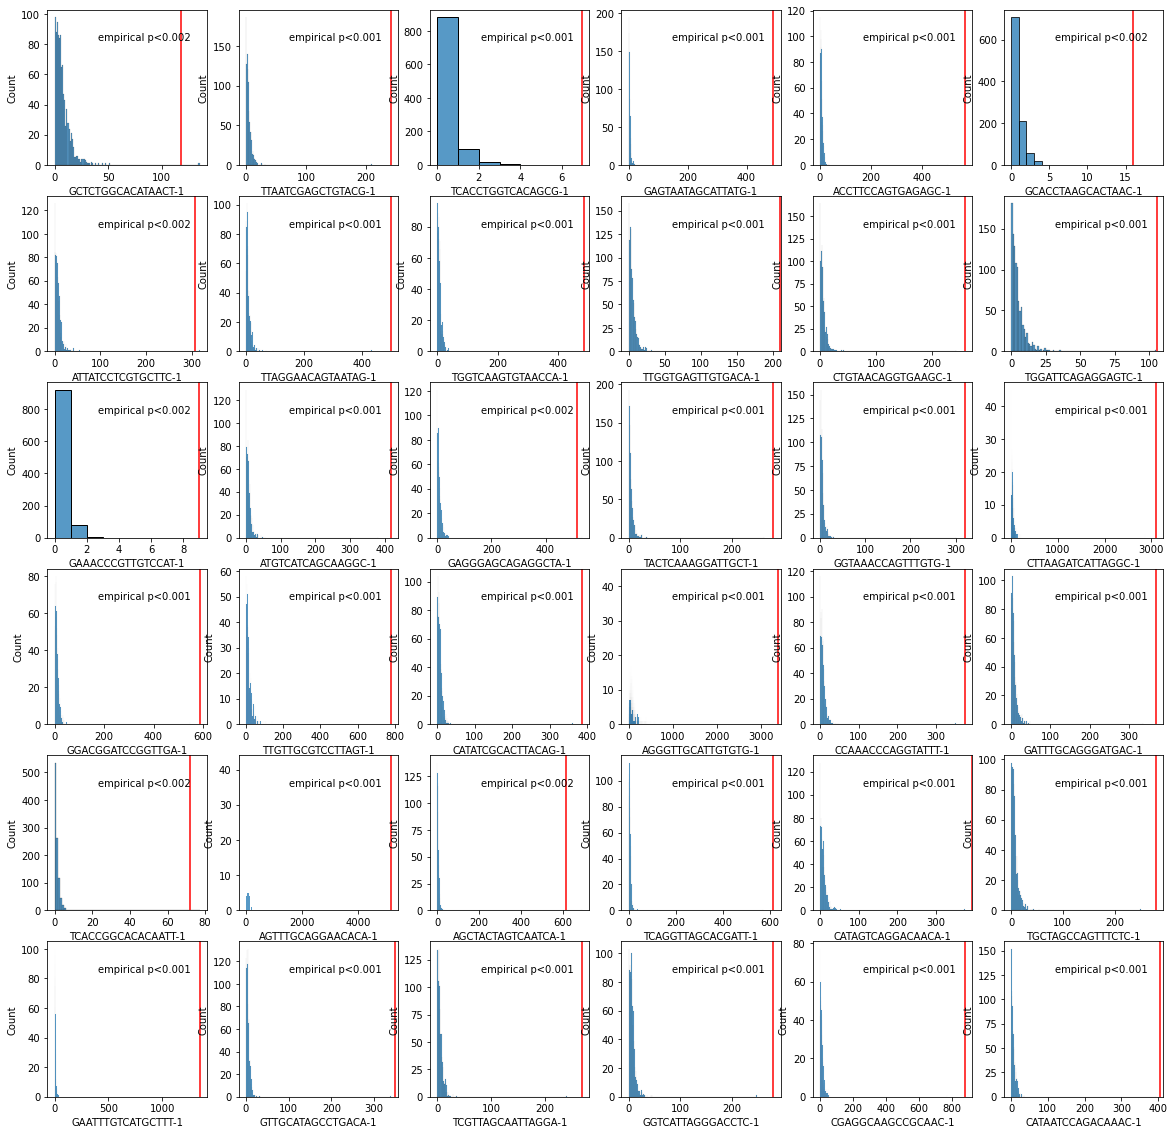

In [8]:
# COLO320DM
root="/mnt/c/Users/ochapman/Documents/Mesirov/scRNA+ATAC/"
SAMPLE=None
fg1 = load_counts('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320DM/COLO320DM_ecDNA0.tsv',2.007952)
bg = load_backgrounds('/home/ochapman/Documents/Mesirov/scRNA+ATAC/2022-01-10_ecdna-quant-out/COLO320DM/COLO320DM_bkgd.tsv')
gen_histograms(fg1,bg)
dm_c = classify([fg1],bg)

<AxesSubplot:xlabel='sample', ylabel='ecDNA1_z-score'>

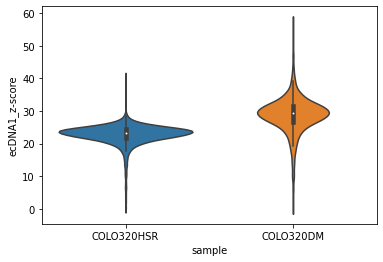

In [10]:
hsr_c["sample"]='COLO320HSR'
dm_c["sample"]='COLO320DM'
df = pd.concat([hsr_c,dm_c])
sns.violinplot(data=df,x='sample',y="ecDNA1_z-score")